**Install deepxde**  
Tensorflow and all other dependencies are already installed in Colab terminals

In [1]:
!pip install deepxde


     |███                             | 10 kB 22.0 MB/s eta 0:00:01
     |█████▉                          | 20 kB 21.5 MB/s eta 0:00:01
     |████████▉                       | 30 kB 10.9 MB/s eta 0:00:01
     |███████████▊                    | 40 kB 8.5 MB/s eta 0:00:01
     |██████████████▊                 | 51 kB 5.5 MB/s eta 0:00:01
     |█████████████████▋              | 61 kB 5.6 MB/s eta 0:00:01
     |████████████████████▋           | 71 kB 5.5 MB/s eta 0:00:01
     |███████████████████████▌        | 81 kB 6.2 MB/s eta 0:00:01
     |██████████████████████████▍     | 92 kB 4.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 102 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 5.3 MB/s 
     |████████████████████████████████| 100 kB 8.9 MB/s 


**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [1]:
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

No backend selected.
Finding available backend...


2023-06-17 20:10:38.472199: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term


2023-06-17 20:10:39.287103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-17 20:10:39.287119: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-17 20:10:39.287132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (da82188e219a): /proc/driver/nvidia/version does not exist


In [2]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [3]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [4]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

Adam optimization.  

In [6]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.039392 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-06-17 20:10:52.900415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.423445 s

Training model...



2023-06-17 20:10:53.294650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.52e+00, 1.74e-01, 7.65e-01, 5.30e-04, 5.84e+00, 3.86e-04, 8.06e-01, 9.62e-01]    [1.52e+00, 1.74e-01, 7.65e-01, 5.30e-04, 5.84e+00, 3.86e-04, 8.06e-01, 9.62e-01]    []  
1000      [1.14e-02, 1.50e-02, 4.07e-02, 3.65e-04, 1.04e-02, 2.64e-05, 3.05e-02, 4.61e-03]    [1.14e-02, 1.50e-02, 4.07e-02, 3.65e-04, 1.04e-02, 2.64e-05, 3.05e-02, 4.61e-03]    []  
2000      [8.50e-03, 9.32e-03, 1.21e-04, 7.65e-05, 2.61e-05, 3.32e-05, 1.78e-02, 1.72e-03]    [8.50e-03, 9.32e-03, 1.21e-04, 7.65e-05, 2.61e-05, 3.32e-05, 1.78e-02, 1.72e-03]    []  
3000      [5.24e-03, 1.08e-02, 2.20e-04, 4.56e-05, 6.39e-04, 2.27e-05, 1.23e-02, 9.07e-04]    [5.24e-03, 1.08e-02, 2.20e-04, 4.56e-05, 6.39e-04, 2.27e-05, 1.23e-02, 9.07e-04]    []  
4000      [4.92e-03, 4.38e-03, 1.72e-05, 1.64e-05, 4.32e-05, 1.38e-05, 1.00e-0

(<deepxde.model.LossHistory at 0x7fcab14783d0>,
 <deepxde.model.TrainState at 0x7fcab1470d60>)

L-BFGS optimization.

In [7]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.268084 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [7.93e-04, 3.79e-03, 3.16e-04, 7.20e-06, 2.87e-05, 3.99e-06, 7.08e-04, 2.57e-05]    [7.93e-04, 3.79e-03, 3.16e-04, 7.20e-06, 2.87e-05, 3.99e-06, 7.08e-04, 2.57e-05]    []  
11000     [3.34e-05, 3.81e-05, 5.40e-07, 1.20e-06, 1.47e-07, 6.53e-07, 1.16e-05, 4.99e-07]    [3.34e-05, 3.81e-05, 5.40e-07, 1.20e-06, 1.47e-07, 6.53e-07, 1.16e-05, 4.99e-07]        
12000     [1.02e-05, 9.81e-06, 3.65e-08, 3.79e-07, 3.08e-07, 3.16e-07, 6.03e-06, 2.90e-07]    [1.02e-05, 9.81e-06, 3.65e-08, 3.79e-07, 3.08e-07, 3.16e-07, 6.03e-06, 2.90e-07]        
13000     [4.85e-06, 4.52e-06, 2.48e-08, 1.89e-07, 8.25e-08, 5.99e-08, 4.31e-06, 1.60e-07]    [4.85e-06, 4.52e-06, 2.48e-08, 1.89e-07, 8.25e-08, 5.99e-08, 4.31e-06, 1.60e-07]        
14000     [3.

(<deepxde.model.LossHistory at 0x7fcab14783d0>,
 <deepxde.model.TrainState at 0x7fcab1470d60>)

Final results.  
The reference solution and further information can be found in [this paper](https://arxiv.org/abs/1711.10561) from Raissi, Karniadakis, Perdikaris.  
The test data can be got [here](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat).

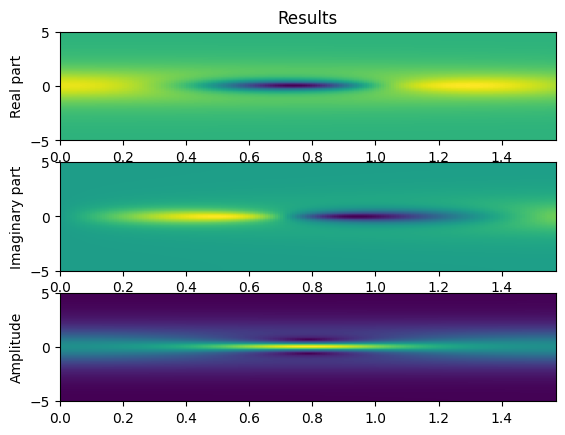

In [8]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

**Assess the accuracy**

We can employ the test data to assess the accuracy of the trained model.  
Using the normalized $L^2$ norm defined as  
  
Error $u$ = $\frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  
  
where $u_{test}$ is the reference solution and $u_{pred}$ is the prediction given by the model, we get:  
  
Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  
  
We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  






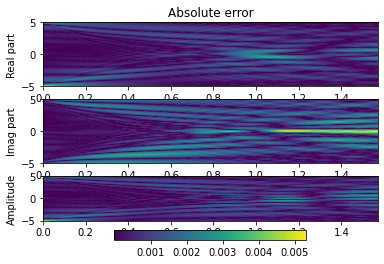